This was the first approach and it is preserved as a comparison as to what happens when there is no lower bound on the cluster sizes. An image from this code shows up in the paper, but it is not meant to be used in the current pseudocode in the paper.

In [1]:
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt

# Plotting functions
def pointDistance(point1, point2):
    value = np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)
    return value

def flipPoint(point1, center):
    deltax = point1[0] - center[0]
    deltay = point1[1] - center[1]
    return (center[0] - deltax, center[1]- deltay)

def computePOI(point1, point2, point3):
    # could not find a good implementation that solves the linear equation, so playing with numpy solver to solve 
    #  the matrix given by ||x-s_1||^2 = ||x-s_2||^2 = ||x-s_3||^2 to solve for the x and y coordinate
    A = np.zeros((2,2))
    b = np.zeros(2)
    #subrtact one of the eqns from the other 2 then they all have to equal 0, so can solve the Ax=b matrix to get
    # the x and y coordinate 
    A[0][0] = -2*point1[0] + 2*point3[0]
    A[0][1] = -2*point1[1] + 2*point3[1]
    A[1][0] = -2*point2[0] + 2*point3[0]
    A[1][1] = -2*point2[1] + 2*point3[1]
    b[0] = -point1[0]*point1[0] - point1[1]*point1[1] + point3[0]*point3[0] + point3[1]*point3[1]
    b[1] = -point2[0]*point2[0] - point2[1]*point2[1] + point3[0]*point3[0] + point3[1]*point3[1]
    return np.linalg.solve(A,b)

def plotPlane(center, sites, index1, index2):
    midpoint = ((sites[index1][0]+sites[index2][0])/2, (sites[index1][1]+sites[index2][1])/2)
    dist = pointDistance(sites[index1], midpoint)
    for c in range(len(sites)):
        if pointDistance(midpoint, sites[c]) < dist:
            break
        elif c == len(sites)-1:
            plt.plot([midpoint[0], point[0]], [midpoint[1], point[1]], 'k-')
            return
    #try other side of midpoint
    midpoint = flipPoint(midpoint, center)
    for c in range(len(sites)):
        if pointDistance(midpoint, sites[c]) < dist:
            break
        elif c == len(sites)-1:
            plt.plot([midpoint[0], point[0]], [midpoint[1], point[1]], 'k-')
            return
    #TODO: will potentially find another common point between index 1 and index 2
    # Will implement multi key dictionary to dray hyperplane when next point is found
    # will be implemented in multipoint demo first
    return

def radialMidpoint(a, b):
    m = (b[1] - a[1])/(b[0]-a[0])
    x = (a[1]*b[0]*m +b[1]*b[1] -b[0]*b[1]*m - a[1]*b[1])/(a[0]+a[1]*m-b[0]-b[1]*m) 
    y = m*(x -b[0])+b[1]
    return (x,y)


Problem declariation below

In [2]:
#starting data, eventually will be read from file
sitesStart= [
    (2.5, 3.0),
    (3.0,-2.0),
    (-2.25,3.0),
    (-3.0,-2.5),
    (1.0, 2.5)
]

sitesEnd = [
    (1.0,1.5),
    (3.1,-3.0),
    (-3.2,3.0),
    (-3.1,-3.25),
    (0.5, 0.5)
]


points = [
    (4.59, 2.25),
    (-4.65, -1.74),
    (1.99, 3.93),
    (-2.33, 3.43),
    (1.02, 4.76),
    (2.11, -0.83),
    (-0.55, -2.69),
    (3.31, 0.77),
    (-4.97, -2.59),
    (-1.16, 4.34),
    (2.08, -4.30),
    (-4.33, 2.21),
    (-4.12, 0.72),
    (2.00, 2.16),
    (0.54, 3.76),
    (-1.59, -3.73),
    (3.69, -1.97),
    (-3.40, -1.25)
]

#Compute weights, needed for breakpoint calculation
def computeWeights(site, point):
    return np.sqrt((point[0]- site[0])**2 +(point[1]-site[1])**2)

def assignPoints( points, sites):
    assignment = np.zeros(len(points))
    for j in range(len(points)):
        dist = 1000
        site = 1000
        for s in range(len(sites)):
            # compute closest and store it for each point
            newDist = np.sqrt((points[j][0]-sites[s][0])**2 + (points[j][1]-sites[s][1])**2)

            if newDist < dist:
                dist = newDist
                site = s
        assignment[j]= site
    return assignment
    
def radialDistance(point, site):
    return point[0]*site[0] + point[1]*site[1]


In [3]:
def plotRadialPlane(sites, index1, index2):
    midpoint = radialMidpoint(sites[index1],sites[index2])
    dist = radialDistance(sites[index1], midpoint)
    for c in range(len(sites)):
        if radialDistance(midpoint, sites[c]) > dist and c != index1 and c != index2 :
            break
        elif c == len(sites)-1:
            if midpoint[0] == 0.0:
                x_steps = 100
            else:
                x_steps = abs(5.0/midpoint[0])
            if midpoint[1] == 0.0:
                y_steps = 100
            else:
                y_steps = abs(5.0/midpoint[1])
            if x_steps <= y_steps:
                plt.plot([0, midpoint[0]*x_steps], [0, midpoint[1]*x_steps], 'k-')
            else:
                plt.plot([0, midpoint[0]*y_steps], [0, midpoint[1]*y_steps], 'k-')
            return
    #try other side of midpoint
    midpoint = flipPoint(midpoint, (0,0))
    for c in range(len(sites)):
        if radialDistance(midpoint, sites[c]) > dist and c != index1 and c != index2 :
            break
        elif c == len(sites)-1:
            if midpoint[0] == 0.0:
                x_steps = 100
            else:
                x_steps = abs(5.0/midpoint[0])
            if midpoint[1] == 0.0:
                y_steps = 100
            else:
                y_steps = abs(5.0/midpoint[1])
            if x_steps <= y_steps:
                plt.plot([0, midpoint[0]*x_steps], [0, midpoint[1]*x_steps], 'k-')
            else:
                plt.plot([0, midpoint[0]*y_steps], [0, midpoint[1]*y_steps], 'k-')
            return

In [4]:
def breakpointDistance(point1, point2):
    #Switching from least squares distance to scalar product
    #value = np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)
    return point1[0]*point2[0] + point1[1]*point2[1]


In [5]:
def genNextCluster(currentSites, endSites, points, currentAssingment, endAssingment, count):
    shift = 2
    pIndex = -1
    sIndex = -1
    for p in range(len(points)):
        #These values will be precomputed in the weighted version of this problem
        if currentAssingment[p] == endAssingment[p]:
            continue
        cBasisOld = breakpointDistance(points[p], currentSites[currentAssingment[p].astype(np.int64)])
        cBasisNew = breakpointDistance(points[p], endSites[currentAssingment[p].astype(np.int64)])
    
        for s in range(len(currentSites)):
            cNonBasisOld = breakpointDistance(points[p], currentSites[s])
            cNonBasisNew = breakpointDistance(points[p], endSites[s])
            #This check does not match the write up
            #if cNonBasisNew - cBasisNew + cBasisOld - cNonBasisOld <= 0:
            if cBasisNew - cNonBasisNew + cNonBasisOld - cBasisOld == 0:
                continue
        
            temp = (cBasisOld - cNonBasisOld)/(cNonBasisNew - cBasisNew + cBasisOld - cNonBasisOld)

            if temp < shift and temp >= 0: 
                shift = temp
                pIndex = p
                sIndex = s

    # computing the next set of sites.    
    tempSites = [
        ((currentSites[0][0] + shift*(endSites[0][0]- currentSites[0][0])),(currentSites[0][1] 
                                                                            + shift*(endSites[0][1]- currentSites[0][1]))),
        ((currentSites[1][0] + shift*(endSites[1][0]- currentSites[1][0])),(currentSites[1][1] 
                                                                            + shift*(endSites[1][1]- currentSites[1][1]))),
        ((currentSites[2][0] + shift*(endSites[2][0]- currentSites[2][0])),(currentSites[2][1] 
                                                                            + shift*(endSites[2][1]- currentSites[2][1]))),
        ((currentSites[3][0] + shift*(endSites[3][0]- currentSites[3][0])),(currentSites[3][1] 
                                                                            + shift*(endSites[3][1]- currentSites[3][1]))),
        ((currentSites[4][0] + shift*(endSites[4][0]- currentSites[4][0])),(currentSites[4][1] 
                                                                            + shift*(endSites[4][1]- currentSites[4][1])))
    ]

    #new point assignment
    if sIndex ==-1:
        return (0,currentSites,currentAssingment)
    tempAssingment = np.copy(currentAssingment)
    tempAssingment[pIndex] = sIndex
    
    #plot breakpoint
    for i in range(len(points)):
        if tempAssingment[i] == 0:
            plt.plot(points[i][0],points[i][1], 'go')
        elif tempAssingment[i] == 1:
            plt.plot(points[i][0],points[i][1], 'bo')
        elif tempAssingment[i] == 2:
            plt.plot(points[i][0],points[i][1], 'ro')
        elif tempAssingment[i] == 3:
            plt.plot(points[i][0],points[i][1], 'co')
        else:
            plt.plot(points[i][0],points[i][1], 'mo')

    #needs hyperplane logic from LSA plotting
    for i in range(len(tempSites)):
        for j in range(i+1,len(tempSites)):
            plotRadialPlane(tempSites, i, j)
        
    plt.plot(tempSites[0][0],tempSites[0][1], 'gx')
    plt.plot(tempSites[1][0],tempSites[1][1], 'bx')   
    plt.plot(tempSites[2][0],tempSites[2][1], 'rx')
    plt.plot(tempSites[3][0],tempSites[3][1], 'cx')
    plt.plot(tempSites[4][0],tempSites[4][1], 'mx')

    plt.xlim(-5.5, 5.5)
    plt.ylim(-5.5, 5.5)
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    filename = "power{count}"
    plt.savefig(filename+".png", bbox_inches='tight', dpi=300)
    plt.savefig(filename+".svg", bbox_inches='tight')

    plt.show()
    newVals = (shift, tempSites, tempAssingment)
    return newVals

This problem is kept as it was the first attempt at the radial clustering, This step was changed after the fact due to 
how artificial the radial clusterings behave in the unbound case.

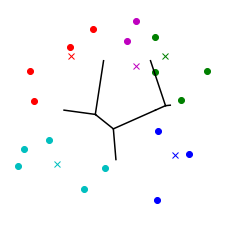

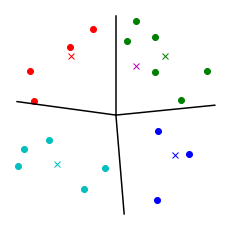

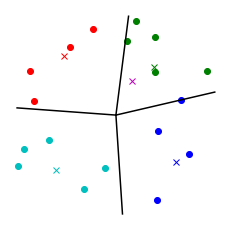

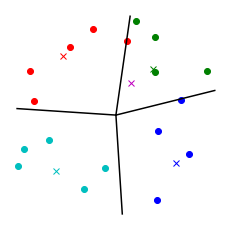

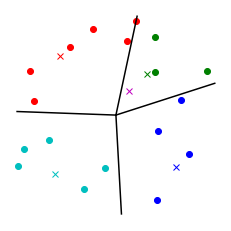

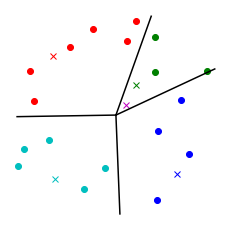

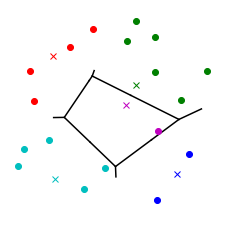

In [6]:
##this case is just a least squares asssignment, so LP for this stage is not a priority
siteAssingmentStart = assignPoints(points, sitesStart)
#print(siteAssingmentStart)
siteAssingmentEnd = assignPoints(points, sitesEnd)
#print(siteAssingmentEnd)

#radial clustering
rAssingmentStart = np.zeros(len(points))
rAssingmentEnd = np.zeros(len(points))
for p in range(len(points)):
    s1 = radialDistance(points[p], sitesStart[0])
    s2 = radialDistance(points[p], sitesStart[1])
    s3 = radialDistance(points[p], sitesStart[2])
    s4 = radialDistance(points[p], sitesStart[3])
    s5 = radialDistance(points[p], sitesStart[4])
    e1 = radialDistance(points[p], sitesEnd[0])
    e2 = radialDistance(points[p], sitesEnd[1])
    e3 = radialDistance(points[p], sitesEnd[2])
    e4 = radialDistance(points[p], sitesEnd[3])
    e5 = radialDistance(points[p], sitesEnd[4])
    if s1>= s2 and s1>= s3 and s1 >= s4 and s1 >= s5:
        rAssingmentStart[p] = 0
    elif s2>= s3 and s2 >s4  and s2 >= s5:
        rAssingmentStart[p] = 1
    elif s3 >= s4 and s3 >= s5:
        rAssingmentStart[p] = 2
    elif s4 >= s5:
        rAssingmentStart[p] = 3
    else: 
        rAssingmentStart[p] = 4
    
    if e1>= e2 and e1>= e3 and e1 >= e4 and e1 >= e5:
        rAssingmentEnd[p] = 0
    elif e2>= e3 and e2 >= e4 and e2 >= e5:
        rAssingmentEnd[p] = 1
    elif e3 >= e4 and e3 >= e5:
        rAssingmentEnd[p] = 2
    elif e4 >= e5: 
        rAssingmentEnd[p] = 3
    else:
        rAssingmentEnd[p] = 4

#start plot
#I'll find a better way to do colors, especially as we add sites. This will also be a function in the next version
for i in range(len(points)):
    if siteAssingmentStart[i] == 0:
        plt.plot(points[i][0],points[i][1], 'go')
    elif siteAssingmentStart[i] == 1:
        plt.plot(points[i][0],points[i][1], 'bo')
    elif siteAssingmentStart[i] == 2:
        plt.plot(points[i][0],points[i][1], 'ro')
    elif siteAssingmentStart[i] == 3:
        plt.plot(points[i][0],points[i][1], 'co')
    else:
        plt.plot(points[i][0],points[i][1], 'mo')
    
plt.plot(sitesStart[0][0],sitesStart[0][1], 'gx')
plt.plot(sitesStart[1][0],sitesStart[1][1], 'bx')   
plt.plot(sitesStart[2][0],sitesStart[2][1], 'rx')
plt.plot(sitesStart[3][0],sitesStart[3][1], 'cx')
plt.plot(sitesStart[4][0],sitesStart[4][1], 'mx')
    
# plotting planes
for i in range(len(sitesStart)):
    for j in range(i+1,len(sitesStart)):
        firstPoint = (-100,-100)
        secondPoint = (-100, -100)
        for k in range(j+1, len(sitesStart)):
            point = computePOI(sitesStart[i], sitesStart[j], sitesStart[k])
            tempdist = pointDistance(point, sitesStart[i])
            if np.sqrt(point[0]**2 + point[1]**2) > 5*np.sqrt(2):
                break
            for n in range(len(sitesStart)):
                #if n==i or n==j or n==k:
                  #  count +=1
                if pointDistance(point, sitesStart[n]) < tempdist  and (n!=i and n!=j and n!=k) :
                    break
                elif n == len(sitesStart)-1:
                    if firstPoint == (-100,-100):
                        firstPoint = (point[0], point[1])
                    elif secondPoint == (-100, -100):
                        secondPoint = (point[0], point[1])
                    
                if n == len(sitesStart)-1:
                    plotPlane(point, sitesStart, i,j)
                    plotPlane(point, sitesStart, j,k)
                    plotPlane(point, sitesStart, k,i)
        if secondPoint != (-100,-100):
            plt.plot([firstPoint[0], secondPoint[0]], [firstPoint[1],secondPoint[1]], 'k-')

plt.xlim(-5.5, 5.5)
plt.ylim(-5.5, 5.5)
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('5ptStart.png', bbox_inches='tight', dpi=300)
plt.savefig('5ptStart.svg', bbox_inches='tight')
plt.show()
#Starting radial clustering
for i in range(len(points)):
    if rAssingmentStart[i] == 0:
        plt.plot(points[i][0],points[i][1], 'go')
    elif rAssingmentStart[i] == 1:
        plt.plot(points[i][0],points[i][1], 'bo')
    elif rAssingmentStart[i] == 2:
        plt.plot(points[i][0],points[i][1], 'ro')
    elif rAssingmentStart[i] == 3:
        plt.plot(points[i][0],points[i][1], 'co')
    else:
        plt.plot(points[i][0],points[i][1], 'mo')
    

plt.plot(sitesStart[0][0],sitesStart[0][1], 'gx')
plt.plot(sitesStart[1][0],sitesStart[1][1], 'bx')   
plt.plot(sitesStart[2][0],sitesStart[2][1], 'rx')
plt.plot(sitesStart[3][0],sitesStart[3][1], 'cx')
plt.plot(sitesStart[4][0],sitesStart[4][1], 'mx')

#needs hyperplane logic from LSA plotting
for i in range(len(sitesStart)):
    for j in range(i+1,len(sitesStart)):
        plotRadialPlane(sitesStart, i, j)
plt.xlim(-5.5, 5.5)
plt.ylim(-5.5, 5.5)
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('5ptradStart.png', bbox_inches='tight', dpi=300)
plt.savefig('5ptradStart.svg', bbox_inches='tight')
plt.show()
####################################
vals = (1, sitesStart, rAssingmentStart)
count = 0
while vals[0] > 0 and count <10:
    vals = genNextCluster(vals[1], sitesEnd, points, vals[2], rAssingmentEnd, count)
    count +=1

####################################
#Ending radial clustering

for i in range(len(points)):
    if rAssingmentEnd[i] == 0:
        plt.plot(points[i][0],points[i][1], 'go')
    elif rAssingmentEnd[i] == 1:
        plt.plot(points[i][0],points[i][1], 'bo')
    elif rAssingmentEnd[i] == 2:
        plt.plot(points[i][0],points[i][1], 'ro')
    elif rAssingmentEnd[i] == 3:
        plt.plot(points[i][0],points[i][1], 'co')
    else:
        plt.plot(points[i][0],points[i][1], 'mo')
    
plt.plot(sitesEnd[0][0],sitesEnd[0][1], 'gx')
plt.plot(sitesEnd[1][0],sitesEnd[1][1], 'bx')   
plt.plot(sitesEnd[2][0],sitesEnd[2][1], 'rx')
plt.plot(sitesEnd[3][0],sitesEnd[3][1], 'cx')
plt.plot(sitesEnd[4][0],sitesEnd[4][1], 'mx')

for i in range(len(sitesEnd)):
    for j in range(i+1,len(sitesEnd)):
        #radpoint = radialMidpoint(sitesEnd[i], sitesEnd[j])
        #print(radpoint)
        #x_range = [0, radpoint[0]]
        #y_range = [0, radpoint[1]]
        #plt.plot(x_range, y_range)
        plotRadialPlane(sitesEnd, i, j)

plt.xlim(-5.5, 5.5)
plt.ylim(-5.5, 5.5)
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('5ptradEnd.png', bbox_inches='tight', dpi=300)
plt.savefig('5ptradEnd.svg', bbox_inches='tight')
plt.show()
#Ending site


for i in range(len(sitesEnd)):
    for j in range(i+1,len(sitesEnd)):
        firstPoint = (-100,-100)
        secondPoint = (-100, -100)
        for k in range(j+1, len(sitesEnd)):
            point = computePOI(sitesEnd[i], sitesEnd[j], sitesEnd[k])
            tempdist = pointDistance(point, sitesEnd[i])
            if np.sqrt(point[0]**2 + point[1]**2) > 5*np.sqrt(2):
                break
            for n in range(len(sitesEnd)):
                #if n==i or n==j or n==k:
                  #  count +=1
                if pointDistance(point, sitesEnd[n]) < tempdist  and (n!=i and n!=j and n!=k) :
                    break
                elif n == len(sitesEnd)-1:
                    if firstPoint == (-100,-100):
                        firstPoint = (point[0], point[1])
                    elif secondPoint == (-100, -100):
                        secondPoint = (point[0], point[1])
                    
                if n == len(sitesStart)-1:
                    plotPlane(point, sitesEnd, i,j)
                    plotPlane(point, sitesEnd, j,k)
                    plotPlane(point, sitesEnd, k,i)
        if secondPoint != (-100,-100):
            plt.plot([firstPoint[0], secondPoint[0]], [firstPoint[1],secondPoint[1]], 'k-')

for i in range(len(points)):
    if siteAssingmentEnd[i] == 0:
        plt.plot(points[i][0],points[i][1], 'go')
    elif siteAssingmentEnd[i] == 1:
        plt.plot(points[i][0],points[i][1], 'bo')
    elif siteAssingmentEnd[i] == 2:
        plt.plot(points[i][0],points[i][1], 'ro')
    elif siteAssingmentEnd[i] == 3:
        plt.plot(points[i][0],points[i][1], 'co')
    else:
        plt.plot(points[i][0],points[i][1], 'mo')
    
plt.plot(sitesEnd[0][0],sitesEnd[0][1], 'gx')
plt.plot(sitesEnd[1][0],sitesEnd[1][1], 'bx')   
plt.plot(sitesEnd[2][0],sitesEnd[2][1], 'rx')
plt.plot(sitesEnd[3][0],sitesEnd[3][1], 'cx')
plt.plot(sitesEnd[4][0],sitesEnd[4][1], 'mx')            
plt.xlim(-5.5, 5.5)
plt.ylim(-5.5, 5.5)
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('5ptEnd.png', bbox_inches='tight', dpi=300)
plt.savefig('5ptEnd.svg', bbox_inches='tight')